# Analysis of Vodafone users' fluxes

The study of the flux of people inside urban areas is of paramount importance to achieve an optimal understanding of emerging critical issues in the local mobility, and to explore areas of potential improvements in the infrastructures and local transports.

The mobility of users within and toward Padova has been monitored using the data provided by the Vodafone mobile carrier, which provides the information based on the users' connections to the network cells.
The data provided by the carrier encompasses the monitoring of the users connected to the Vodafone network in Padova in a four-month period from February to May of 2018.

To provide statistical insights on the number and the flow of users, the data is aggregated based on the origin and movements of the users by averaging the number of connections during the time of the monitoring.

To further avoid privacy violation issues, all observations with less than 30 units (e.g. day-areas for which $<$30 users have contributed) have been discarded and/or merged into dedicated categories (indicated with "altro", or "other").


## Datasets 

The data is provided in `.csv` files.

* __day_od.csv__: table of the origins and destinations of the users averaged by the day of the week. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).
* __distinct_users_day.csv__: table of the number of distinct users by origin. The data is provided with details of the month, type of user (resident in Padova/Italian visitor/foreign visitor), country of provenance, together with the province and comune of the user (if available).

The information is stored in the fields according to the following scheme: 

- __MONTH__: month analyzed
- __DOW__: day analyzed
- __ORIGIN__: users' origin area (do not consider this field)
- __DESTINATION__: users' destination area (do not consider this field)
- __CUST_CLASS__: user type (resident / Italian visitor / foreigner visitor)
- __COD_COUNTRY__: users' country code (e.g. 222=Italy)
- __COD_PRO__: users' province code (e.g. 12=Varese) 
- __PRO_COM__: users' comune code (e.g. 12026=Busto Arsizio)
- __FLOW__: number of movements for given date-time (with a minimum of 30 users)
- __VISITORS__: overall number of users 

Together with the data files, three lookup-tables are provided to allow matching the Italian institute of STATistics (ISTAT) country, province and comune codes to the actual names.

* __codici_istat_comune.csv__: lookup file containing the mapping between _comune_ ISTAT code-names
* __codici_istat_provincia.csv__: lookup file containing the mapping between _province_ ISTAT code-names
* __codici_nazioni.csv__: lookup file containing mapping the _country_ code to its name

Additional information, useful for the study of the flow of users, as the number of inhabitants of each province and the distance between Padova and all other Italian provinces can be extracted based on the data collected by the ISTAT:

   - English: https://www.istat.it/en/analysis-and-products/databases, Italian: https://www.istat.it/it/dati-analisi-e-prodotti/banche-dati
   
   - English/Italian: https://www.istat.it/en/archive/157423, Italian: https://www.istat.it/it/archivio/157423
   
   - `.zip` package containing the distances between comuni in Veneto region: http://www.istat.it/storage/cartografia/matrici_distanze/Veneto.zip

If deemed useful, the open repository [https://github.com/openpolis/geojson-italy](https://github.com/openpolis/geojson-italy) contains a `.json` file with the geographical coordinates of the provences and comuni of Italy.


## Assignments

1. Data preparation: the csv files are originated from different sources, hence resulting in differences in the encoding and end-of-lines that have to be taken into account in the data preparation phase. Make sure each .csv file is properly interpreted.

   1.1 Ranking of visitors from foreign countries: based on the number of total visitors per each country, create a ranked plot of the first 20 countries with the most visitors
   
   1.2 Ranking of Italian visitors by province, weighted by the number of inhabitants: based on the number of total visitors per Italian province, create a ranked plot of the first 20 provinces with the most visitors taking into account the number of inhabitants.


2. Study of the visitors' fluxes: you are asked to provide indications on how to invest resources to improve the mobility towards Padova. Consider the three main directions of visitors and commuters getting to Padova through the main highways (from south, A13 towards Bologna-Roma; from west, A4 towards Milano-Torino; from north-east, A4 towards Venice-Trieste). Evaluate which of the three directions has to be prioritized.

   2.1 Consider a simplified case involving only the mid-range mobility, based on the number of visitors/commuters from the nearby regions only
   
   2.2 Consider the provinces located on the three directions that are mostly contributing to the flow of weekend visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. Use the data available to provide what you believe is the best possible answer.


3. Plot the distribution of the number of visitors by the distance of the province of origin. Determine which kind of function should be used to describe the distribution.

   3.1 Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. Illustrate the difference between the resulting regression with respect to the numbers provided by the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

In [130]:

import pandas as pd 
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1.1
df_codici_nazioni = pd.read_csv('codici_nazioni.csv',sep=',',encoding='utf-16') # mbcs indicates the csv file was UCS-2 BE BOM encoded, not UTF-8.

#df_codici_nazioni

df_codici_istat_provincia = pd.read_csv('codici_istat_provincia.csv',sep=',',encoding='latin-1',header=0)
#df_codici_istat_provincia

df_codici_istat_comune = pd.read_csv('codici_istat_comune.csv',sep=',',encoding='latin-1',header=0)
#print(df_codici_istat_comune)

df_distinct_users = pd.read_csv('distinct_users_day.csv',sep=',',encoding='latin-1')
print(df_distinct_users)

df_day_od_orj = pd.read_csv('day_od.csv',sep=',',encoding='utf-16',header=0)
#df_day_od

             DOW CUST_CLASS  COD_COUNTRY  COD_PRO   PRO_COM  VISITORS
0      Mercoledì    visitor        222.0     35.0   35033.0       968
1         Lunedì    visitor        222.0     22.0   22098.0        64
2       Domenica    visitor        222.0     52.0   52032.0       516
3        Giovedì    visitor        222.0    108.0  108009.0       128
4        Giovedì    visitor        222.0     29.0   29048.0       512
...          ...        ...          ...      ...       ...       ...
12840  Mercoledì  foreigner        259.0      NaN       NaN       176
12841     Sabato  foreigner        602.0      NaN       NaN       164
12842    Giovedì  foreigner        732.0      NaN       NaN        80
12843    Giovedì  foreigner        297.0      NaN       NaN        80
12844   Domenica  foreigner        748.0      NaN       NaN        60

[12845 rows x 6 columns]


In [7]:
'''
df_ranking = df_distinct_users[df_distinct_users['CUST_CLASS']=="foreigner"].merge(df_codici_nazioni)
# Ranking of foreign visitors
df_ranking_20 = df_ranking.groupby('COUNTRY_NAME_IT').sum('VISITORS').sort_values(by="VISITORS", ascending=False).head(20)
df_ranking_20 = df_ranking_20.reset_index()

ax = df_ranking_20.plot.bar(x='COUNTRY_NAME_IT', y='VISITORS',figsize=(30, 15))
ax.set_title('The First 20 Countries With the Most Visitors', fontdict={'size':32})
ax.set_ylabel(ylabel='Visitor Number', fontdict={'size':22})
ax.set_xlabel(xlabel='Countries', fontdict={'size':22})

# Ranking of Italian visitors
df_ranking_italian = df_distinct_users[df_distinct_users['CUST_CLASS']=="visitor"].merge(df_codici_istat_comune)

df_ranking_italian_20 = df_ranking_italian[df_ranking_italian['COD_COUNTRY']==222].groupby('COMUNE').sum().sort_values(by="VISITORS", ascending=False).head(20)
df_ranking_italian_20 = df_ranking_italian_20.reset_index()

bx = df_ranking_italian_20.plot.bar(x='COMUNE', y='VISITORS',figsize=(30, 15))
bx.set_title('The First 20 Province With the Most Visitors', fontdict={'size':32})
bx.set_ylabel(ylabel='Visitor Number', fontdict={'size':22})
bx.set_xlabel(xlabel='Province', fontdict={'size':22})

'''

'\ndf_ranking = df_distinct_users[df_distinct_users[\'CUST_CLASS\']=="foreigner"].merge(df_codici_nazioni)\n# Ranking of foreign visitors\ndf_ranking_20 = df_ranking.groupby(\'COUNTRY_NAME_IT\').sum(\'VISITORS\').sort_values(by="VISITORS", ascending=False).head(20)\ndf_ranking_20 = df_ranking_20.reset_index()\n\nax = df_ranking_20.plot.bar(x=\'COUNTRY_NAME_IT\', y=\'VISITORS\',figsize=(30, 15))\nax.set_title(\'The First 20 Countries With the Most Visitors\', fontdict={\'size\':32})\nax.set_ylabel(ylabel=\'Visitor Number\', fontdict={\'size\':22})\nax.set_xlabel(xlabel=\'Countries\', fontdict={\'size\':22})\n\n# Ranking of Italian visitors\ndf_ranking_italian = df_distinct_users[df_distinct_users[\'CUST_CLASS\']=="visitor"].merge(df_codici_istat_comune)\n\ndf_ranking_italian_20 = df_ranking_italian[df_ranking_italian[\'COD_COUNTRY\']==222].groupby(\'COMUNE\').sum().sort_values(by="VISITORS", ascending=False).head(20)\ndf_ranking_italian_20 = df_ranking_italian_20.reset_index()\n\nbx = d

In [275]:
from shapely.geometry import Point, Polygon
from shapely import wkt
import geopandas as gpd
import geojsonio

# Italy and only visitor type users have been filtered.
df_distinct_users1 = df_distinct_users[df_distinct_users['CUST_CLASS']=="visitor"]
df_distinct_users1 = df_distinct_users1[df_distinct_users1['COD_COUNTRY']==222]
#print(df_distinct_users)
# Data read for regions(To obtain the nearby region names) 
geo_data_regions = gpd.read_file('limits_IT_regions.geojson')
# Data cleaning according to province codes.
df_codici_istat_provincia = df_codici_istat_provincia[df_codici_istat_provincia['COD_PRO']>0]

# Combined mask for nearest regions of Padova
nearby_data_regions = geo_data_regions[(geo_data_regions['reg_name']=="Lombardia") | (geo_data_regions['reg_name']=="Friuli-Venezia Giulia") | (geo_data_regions['reg_name']=="Emilia-Romagna")] 

# to find out the provinces included in 3 different regions. 
nearby_data_province = pd.merge(nearby_data_regions,df_codici_istat_provincia, how='left',left_on=['reg_istat_code_num'],right_on=['COD_REG']).dropna()
#geo_data_RP
# to find out the visitor numbers of the regions
num_data_Users = nearby_data_province.merge(df_distinct_users1)
#geo_data_final

# Total number of visitors in the regions.
flux_data = num_data_Users.groupby(['reg_name','COD_REG']).sum().sort_values('VISITORS',ascending=False)
# Number of people 

flux_data








,,reg_istat_code_num,COD_PRO,COD_COUNTRY,PRO_COM,VISITORS
reg_name,COD_REG,,,,,
Lombardia,3,7878,73708,582972.0,73953176.0,360480
Emilia-Romagna,8,9016,44641,250194.0,44665405.0,233648
Friuli-Venezia Giulia,6,4026,32723,148962.0,32755096.0,111564


In [224]:
#2.2 Consider the provinces located on the three directions that are mostly contributing to the flow of weekend 
#visitors and working daily commuters by performing a more detailed study of the fluxes based on the day of the week. 
#Use the data available to provide what you believe is the best possible answer.

# Filtering the data due to unknown or missing rows. i.e PRO_COM = -999.0
df_day_od = df_day_od_orj.copy()
df_day_od = df_day_od[df_day_od['PRO_COM']>0]
df_day_od = df_day_od[df_day_od['COD_PRO']>0]
# Filtering only visitors from Italy
df_day_od = df_day_od[df_day_od['COD_COUNTRY']==222]
# Visitors, resident workers or Altro(maybe the workers from outside to Padova) 
# must be considered for more detailed study.
df_day_od = df_day_od[df_day_od['CUST_CLASS']!='foreigner']
# Some of the unused columns are dropped for better visualization
df_day_od = df_day_od.drop(columns=['ORIGIN','DESTINATION','PRO_COM','MONTH'])

# We merged 2 data frame 
df_day_od = df_day_od.merge(df_codici_istat_provincia)
# Only nearby provinces are considered in each direction.
df_day_od = df_day_od[(df_day_od['PROVINCIA']=='Vicenza') | (df_day_od['PROVINCIA']=='Venezia') | (df_day_od['PROVINCIA']=='Treviso') | (df_day_od['PROVINCIA']=='Rovigo')]
# Drop unnecessary columns
df_day_od = df_day_od.drop(columns=['COD_REG','COD_COUNTRY','PROV_SIGLA'])
# Group according to Provinces, cust_class and the day of the week.
direction_vector = []
for i in df_day_od['PROVINCIA']:
    if i == 'Rovigo':
        direction_vector.append('S')
    elif i == 'Vicenza':
        direction_vector.append('E')
    else:
        direction_vector.append('W')

df_day_od['Directions'] = direction_vector
        
week_vector = []
for j in df_day_od['DOW']:
    if j == 'Sabato' or j=='Domenica':
        week_vector.append('WE')
    else:
        week_vector.append('WD')
        
        
df_day_od['DayOfWeek'] = week_vector    

df_day_od = df_day_od.drop(columns=['DOW','PROVINCIA','COD_PRO'])

df_directions = df_day_od.groupby(['CUST_CLASS','Directions','DayOfWeek']).sum()

df_directions
    


FLOW
CUST_CLASS Directions DayOfWeek        
visitor    E          WD         147947
                      WE          27360
           S          WD          58065
                      WE          13270
           W          WD         608627
                      WE         120261

In [ ]:
# Plot the distribution of the number of visitors by the distance of the province of origin. 
# Determine which kind of function should be used to describe the distribution.
# 3.1 Assuming an analytic form can be used to describe the trend, create a regression or a fit to estimate 
# the expected number of visitors by the distance of the province of origin and the corresponding uncertainties. 
# Illustrate the difference between the resulting regression with respect to the numbers provided by 
# the Vodafone monitoring, and highlight the five most striking discrepancies from the expectations.

         VISITORS
COD_PRO          
1.0         39068
2.0          1940
3.0          9164
4.0          3372
5.0          1440
...           ...
105.0          32
107.0         520
108.0       30648
109.0        2676
110.0        4236

[108 rows x 1 columns]
    prov_name  prov_istat_code_num  Distances_to_Padova  VISITORS
0      Torino                    1         4.873764e+05   39068.0
1    Vercelli                    2         4.016314e+05    1940.0
2      Novara                    3         3.638422e+05    9164.0
3       Cuneo                    4         4.892190e+05    3372.0
4        Asti                    5         4.099965e+05    1440.0
..        ...                  ...                  ...       ...
101  Siracusa                   89         1.273902e+06    1552.0
102   Sassari                   90         7.673450e+05    2832.0
103     Nuoro                   91         8.271407e+05     136.0
104  Cagliari                   92         9.697096e+05    4796.0
105  Oristano   

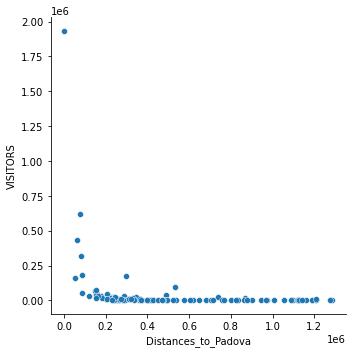

In [317]:
import seaborn as sns
from shapely.geometry import Point, Polygon
import geopandas as gpd
import geojsonio


geo_data_pro = gpd.read_file('limits_IT_provinces.geojson')
# Dropped unnecessary columns.
geo_data_pro = geo_data_pro.drop(columns= ['prov_acr','reg_name','reg_istat_code','prov_istat_code','reg_istat_code_num'])
#geo_data_pro

#df_visitors = df_distinct_users.drop(columns=['DOW','PRO_COM','COD_COUNTRY'])

df_visitors = df_distinct_users[df_distinct_users['CUST_CLASS']=='visitor']

df_visitors = df_visitors.groupby(['COD_PRO']).sum()

print(df_visitors)
# Used Mercator projection(crs=3395), which is good for the locations near to equator. 
geo_data_pro = geo_data_pro.to_crs(epsg=3395)
#Center point of Padova
Polygon_Padova = geo_data_pro[geo_data_pro['prov_istat_code_num']==28]['geometry']
#from geometry object(Polygon), center point can be easily obtained.
# iloc is very important here because the object is GeoSeries, the first element of it gives point object!!!
Center_Padova = Polygon_Padova.centroid.iloc[0]





#print(Center_Padova.geom_type)
distance_list = []
for d in geo_data_pro['geometry']:
    #print(type(d))
    pro_center = d.centroid
    #print(type(pro_center))
    #print(Center_Padova)
    #print(pro_center.distance(Center_Padova.geometry))
    distance_list.append(pro_center.distance(Center_Padova))

geo_data_pro['Distances_to_Padova'] = distance_list
geo_data_pro = geo_data_pro.drop(columns=['geometry'])
#geo_data_pro

Visitors_Distance = pd.merge(geo_data_pro,df_visitors,how='left',left_on=['prov_istat_code_num'],right_on=['COD_PRO']).dropna()
print(Visitors_Distance)
# Scatter plot using seaborn.
sns.relplot(x="Distances_to_Padova", y="VISITORS", data=Visitors_Distance)
#sns.histplot(data=Visitors_Distance,x="Distances_to_Padova",y="VISITORS")
#sns.displot(data=Visitors_Distance,x="Distances_to_Padova",y="VISITORS",kind='hist')
